# Diabetic Retinopathy Detection

### The complete problem statement and dataset can be found at : https://www.kaggle.com/c/diabetic-retinopathy-detection

## Loading libraries

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import time
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import skimage
import keras
from keras.layers import Conv2D,Activation,MaxPooling2D,AveragePooling2D,BatchNormalization,Dropout,Flatten,Dense
from keras.models import Model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.layers import LeakyReLU
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [3]:
trainLabels = pd.read_csv('../input/trainLabels.csv')
trainLabels.head(10)

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
8,17_left,0
9,17_right,1


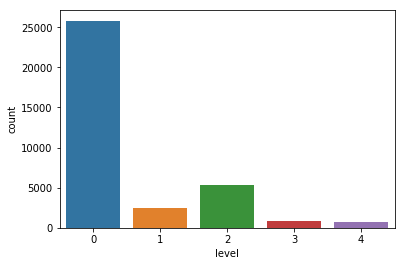

In [4]:
# visualizing distribution of different classes
sns.countplot("level",data = trainLabels)


The data is highly imbalanced. We will be adopting data augmentation technique to tackle this.

In [5]:
listing = os.listdir("../input") 
listing.remove("trainLabels.csv")
np.size(listing)

1000

In [6]:
# input image dimensions
img_rows, img_cols = 229, 229

immatrix = []
imlabel = []

for file in listing:
    base = os.path.basename("../input/" + file)
    fileName = os.path.splitext(base)[0]
    imlabel.append(trainLabels.loc[trainLabels.image==fileName, 'level'].values[0])
    im = Image.open("../input/" + file)   
    img = im.resize((img_rows,img_cols))
    ''' 
    The following four commented lines are meant to apply CLAHE filtering algorithm to the images in order to improve contrast
    brightness. They will be particularly useful if we train our model from scratch instead of using transfer learning.
    '''
    #image = skimage.color.rgb2lab(img)
    #img = img.astype(np.float32)/255
    #img = skimage.exposure.equalize_adapthist(image, kernel_size = 8, clip_limit=0.01, nbins=256)
    #img = im.resize((img_rows,img_cols))
    rgb = img.convert('RGB')
    immatrix.append(np.array(rgb).flatten())

In [7]:
#converting images & labels to numpy arrays
immatrix = np.asarray(immatrix)
imlabel = np.asarray(imlabel)


data,Label = shuffle(immatrix,imlabel, random_state=2)
train_data = [data,Label]
type(train_data)

list

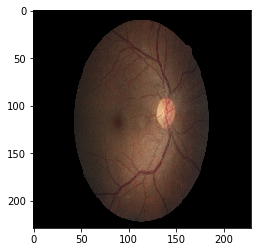

In [8]:
for i in range (10):
    img=immatrix[i].reshape(img_rows,img_cols,3)
    if(imlabel[i]>0):
        plt.imshow(img)

## Using transfer learning with different CNN architectures 

In [9]:
#base_model = VGG16(weights='imagenet',include_top = False,input_shape-(224,224,3))
#base_model = ResNet50(weights='imagenet',include_top = False,input_shape-(224,224,3))
base_model = Xception(weights='imagenet',include_top = False,input_shape=(229,229,3))
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 229, 229, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 114, 114, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 114, 114, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 114, 114, 32) 0           block1

In [10]:
batch_size = 32
num_classes = 5
epochs = 4

### Using Xception as base model and making our own classifier on top of it. The layers in the base model are kept frozen and are not retrained.

In [19]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024))
model.add(LeakyReLU(0.01))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 123,628,077
T

### Preparing training and test data

In [12]:
(X, y) = (train_data[0],train_data[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 3)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 3)
X_train = X_train.astype(np.float32)/255
X_test = X_test.astype(np.float32)/255


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 229, 229, 3)
(800,)
(200, 229, 229, 3)
(200,)


In [13]:
Y_train = np_utils.to_categorical(y_train,num_classes)
Y_test = np_utils.to_categorical(y_test,num_classes)

### Using data augmentation to tackle the problem of imbalanced classes and to prevent overfitting. This technique can be particularly useful for the mild cases of diabetic retinopathy whose diagnosis is much difficult that other cases.

In [20]:
# Data Augmentation

data_generator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=15,zoom_range=0.1 )

In [21]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

In [22]:
optimizer = keras.optimizers.adam(lr = 0.001)

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [27]:
model.fit_generator(data_generator.flow(X_train,Y_train,batch_size = batch_size), steps_per_epoch=int(len(X_train)/batch_size), 
                    epochs=4,callbacks = [es,chkpt],validation_data = (X_test,Y_test))

Epoch 1/4
25/25 [==============================] - 12s 494ms/step - loss: 0.3841 - acc: 0.8500 - val_loss: 2.9846 - val_acc: 0.7450
Epoch 2/4
25/25 [==============================] - 12s 479ms/step - loss: 0.3044 - acc: 0.8800 - val_loss: 3.2611 - val_acc: 0.7350
Epoch 3/4
25/25 [==============================] - 12s 476ms/step - loss: 0.3419 - acc: 0.8725 - val_loss: 2.1329 - val_acc: 0.7300
Epoch 4/4
25/25 [==============================] - 12s 477ms/step - loss: 0.3304 - acc: 0.8625 - val_loss: 3.1891 - val_acc: 0.7300


In [28]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

[3.1890827655792235, 0.73]


## Inference and Conclusion
### 1.With other models(ResNet50,VGG16 and InceptionV3), the accuracy tends to saturate afte 2-3 epochs but with Xception model, accuracy tends to increase.
### 2. The test data accuracy is similar for all achitectures.
### 3. Since the medical images dataset is completely different from ImageNet dataset, retraining some of the layers of the base model or training it from scratch can help improve the accuracy a lot.

## Citations and helpful resources
1. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5961805/
2. http://blog.kaggle.com/2015/08/14/diabetic-retinopathy-winners-interview-4th-place-julian-daniel/
3. https://www.kaggle.com/tanumoynandy/diabeticretinopathyvgg16-finetuning